REFERENCES
1. https://towardsdatascience.com/creating-image-classification-model-with-bayesian-perspective-a90a5956b14e
2. https://keras.io/examples/keras_recipes/bayesian_neural_networks/

# Importing Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Unzip image file data**

In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/COSC2673 - Machine Learning Assignment 2/Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

#### **Reading 'mainData' CSV file**

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


# Exploratory Data Analysis

Trends in the .csv file are explored and visualised to determine effective approaches for the model as well as what general predictions the model may make.



In [ ]:
# Checking if any NaN values are in the dataset
data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

#### **Data Balance and Imbalance**

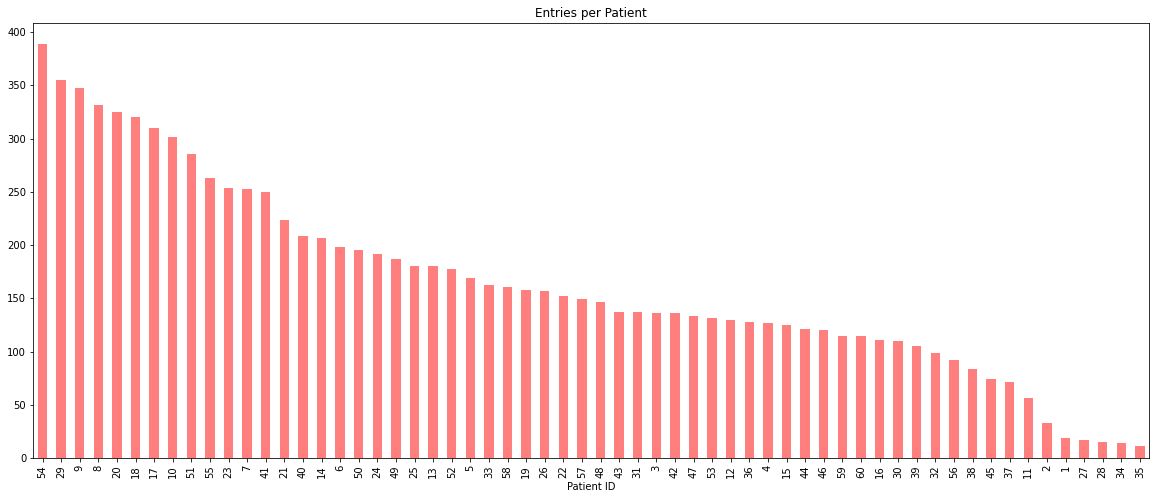

In [ ]:
# Plot the number of entries within the data set per patient
plt.figure(figsize=(20,8))
data['patientID'].value_counts().plot(kind='bar', rot=0, color=['red'], alpha=0.5)
plt.title("Entries per Patient")
plt.xticks(rotation='vertical')
plt.xlabel("Patient ID")

plt.show()

From the above data, it can be seen that the number of datapoints per patient (a total of 60 patients in the main data set) varies greatly between a range of roughly 10 to 400, making it unbalanced.

Another thing to take into account is that although it is normally expected that ID values should not have influence over the training of a machine learning model, datapoints in this case can originate from the same patient, adding bias to the data. This would eventuate data leaks between the test and training data sets if patient ID is not taken into account when splitting. 

In saying this, a possible solution to this would be to perform splits while ensuring that datapoints from the same patient ID are kept grouped together. For example, all datapoints from patients 1, 2, 3, 4, 5 can be set aside for training and datapoints from patients 6, 7, 8, 9, 10 can be set aside for testing (given that the number of datapoints within the split data sets are proportioned)

=======================================================

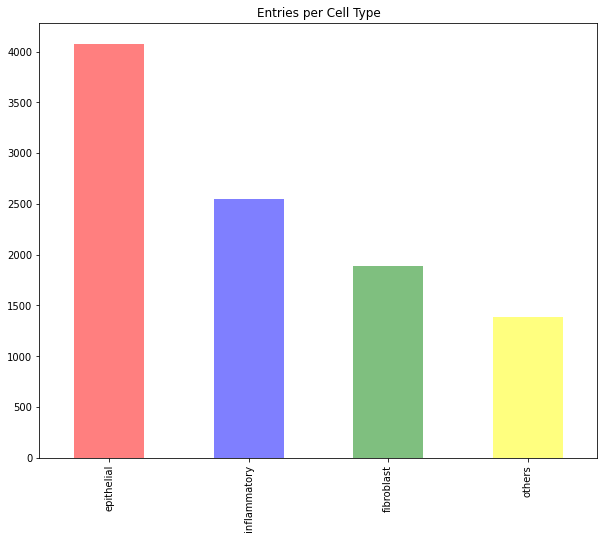

epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64


In [ ]:
# Plot the number of entries within the data set per cell type
plt.figure(figsize=(10,8))
data['cellTypeName'].value_counts().plot(kind='bar', rot=0, color=['red', 'blue', 'green', 'yellow'], alpha=0.5)
plt.title("Entries per Cell Type")
plt.xticks(rotation='vertical')

plt.show()

print(data['cellTypeName'].value_counts())

It can be see that there is an imbalance in the frequencies of the different cell types, however, apart from the 'others' type, there is only little difference.

=======================================================

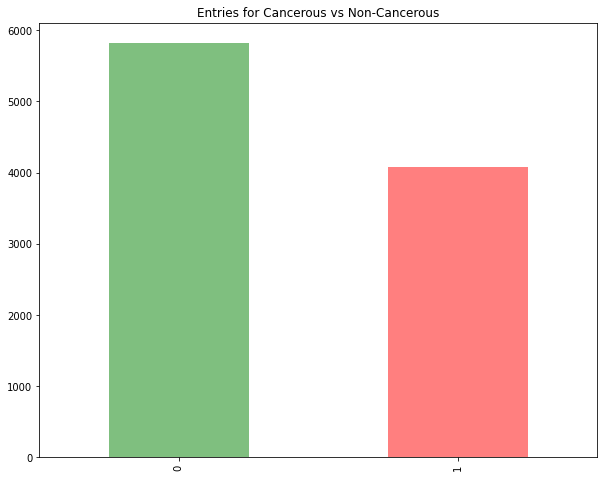

0    5817
1    4079
Name: isCancerous, dtype: int64


In [ ]:
# Plot the number of entries within the data set based on whether the cell is cancerous or not
plt.figure(figsize=(10,8))
data['isCancerous'].value_counts().plot(kind='bar', rot=0, color=['green', 'red'], alpha=0.5)
plt.title("Entries for Cancerous vs Non-Cancerous")
plt.xticks(rotation='vertical')

plt.show()

print(data['isCancerous'].value_counts())

Above, there is an imbalance in the frequencies of datapoints that are labelled cancerous and non-cancerous, however this can be considered a small difference and is expected to cause little influence on the training of the model.

#### **Frequency of Cancerous & Non-Cancerous Cells vs Cell Type**

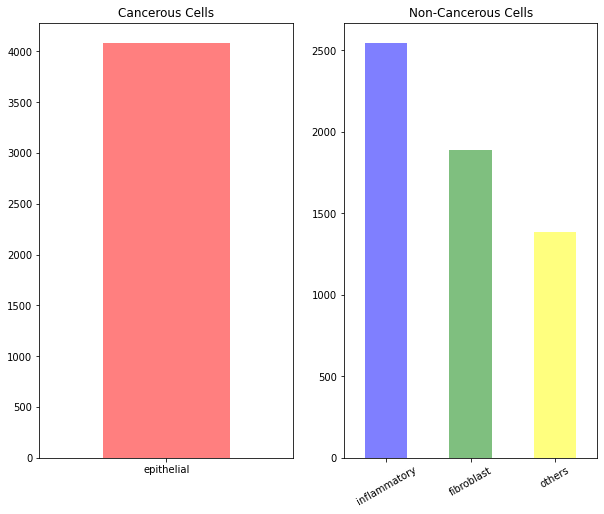

In [ ]:
# Split data into cancerous and non-cancerous sets for plotting
cancerousCellData = data[data['isCancerous'] == 1]
nonCancerousCellData = data[data['isCancerous'] == 0]

# Plotting the number of cancerous and non-cancerous cells against cell type
plt.figure(figsize=(10,8))

plt.subplot(1, 2, 1)
plt.title("Cancerous Cells")
cancerousCellData['cellTypeName'].value_counts().plot(kind='bar', rot=0, color=['red'], alpha=0.5)

plt.subplot(1, 2, 2)
plt.title("Non-Cancerous Cells")
nonCancerousCellData['cellTypeName'].value_counts().plot(kind='bar', rot=0, color=['blue', 'green', 'yellow'], alpha=0.5)
plt.xticks(rotation=30)

plt.show()

From the above data, it can be seen that 100% of the cells that have been labelled cancerous have been labelled the epithelial cell type, while 100% of the non-cancerous cells are of inflammatory, fibroblast and other cell types.

This indicates that training a model with this data will cause it to predict cancerous cells to be of epithelial cell type and epithelial cells to be cancerous.

# Data Pre-Processing

In [5]:
# Removes the 'InstanceID' column
data = data.drop(['InstanceID'], axis=1)

#### **REDUNDANT One-Hot Encoding**
Using one-hot encoding the split the categories of  'cellTypeName' into 4 separate columns

In [ ]:
from sklearn.preprocessing import OneHotEncoder

OneHotEncoder_cellTypeName = OneHotEncoder(handle_unknown='ignore')
OneHotEncoder_cellTypeName.fit(data[['cellTypeName']])

onehot_ = OneHotEncoder_cellTypeName.transform(data[['cellTypeName']]).toarray()

print(OneHotEncoder_cellTypeName.categories_)

colName = 'cellTypeName'
for i in range(len(OneHotEncoder_cellTypeName.categories_[0])):
    data['CellType_' + str(OneHotEncoder_cellTypeName.categories_[0][i])] = onehot_[:,i]

data = data.drop(['cellTypeName', 'cellType'], axis=1)
data.head()

[array(['epithelial', 'fibroblast', 'inflammatory', 'others'], dtype=object)]


,patientID,ImageName,isCancerous,CellType_epithelial,CellType_fibroblast,CellType_inflammatory,CellType_others
0,1,22405.png,0,0.0,1.0,0.0,0.0
1,1,22406.png,0,0.0,1.0,0.0,0.0
2,1,22407.png,0,0.0,1.0,0.0,0.0
3,1,22408.png,0,0.0,1.0,0.0,0.0
4,1,22409.png,0,0.0,1.0,0.0,0.0


#### **Data Splitting**
TODO: data should be split without leakage -> ie patient 1,2,3 for train, 4,5 for validation and 6 for testing.

In [ ]:
data.groupby(by='patientID').count()

,ImageName,cellTypeName,cellType,isCancerous
patientID,,,,
1,19,19,19,19
2,33,33,33,33
3,136,136,136,136
4,127,127,127,127
5,169,169,169,169
6,198,198,198,198
7,253,253,253,253
8,332,332,332,332
9,348,348,348,348


In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data: {} | Validation Data: {} | Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data: 5937 | Validation Data: 1979 | Test Data: 1980


# Classification of Cancerous Cells
Following is a model made designed to predict cancerous from non-cancerous cells.


In [22]:
# Constant variables

IMAGE_SIZE = (27, 27)

# Images are 27x27 in size, and have 3 dimensions for the RGB colouring of each pixel
INPUT_DIM = (27, 27, 3)

# TESTING output for Cancerous & Non-Cancerous (2 classes)
OUTPUT_CLASSES = 2

#### **Image Data Generator**



In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert types to string for the target value
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

train_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
val_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
test_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')

batch_size = 27

# Data generator for training set
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_data,
        directory = './Image_classification_data/patch_images',
        x_col = "ImageName",
        y_col = "isCancerous",
        target_size = IMAGE_SIZE,
        batch_size = batch_size,
        class_mode = 'categorical')

# Data generator for validation set
validation_generator = val_datagen.flow_from_dataframe(
        dataframe = val_data,
        directory = './Image_classification_data/patch_images',
        x_col = "ImageName",
        y_col = "isCancerous",
        target_size = IMAGE_SIZE,
        batch_size = batch_size,
        class_mode = 'categorical')


batch_size = 1

# Data generator for testing set
test_generator = test_datagen.flow_from_dataframe(
        dataframe = test_data,
        directory = './Image_classification_data/patch_images',
        x_col = "ImageName",
        y_col = "isCancerous",
        target_size = IMAGE_SIZE,
        batch_size = batch_size,
        class_mode = 'categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### **Plot Learning Curve Function**

In [24]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Baseline Model
This is a baseline model for other model implementations to follow. It uses only tensorflow keras' neural network image learning with random data splitting.

#### **Baseline Model Building**

In [25]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

# Hyper-parameter determining the number of hidden layers; can be tuned
HIDDEN_LAYER_DIM = 100

In [27]:
# Building the layers of the neural network model
base_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [28]:
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               218800    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 219,002
Trainable params: 219,002
Non-trainable params: 0
_________________________________________________________________


In [30]:
base_model.compile(optimizer = 'SGD',
                   loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
                   metrics = ['categorical_accuracy'])

#### **Performance Measure**

In [34]:
base_history = base_model.fit_generator(train_generator, validation_data = validation_generator, epochs = 30, verbose = 0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


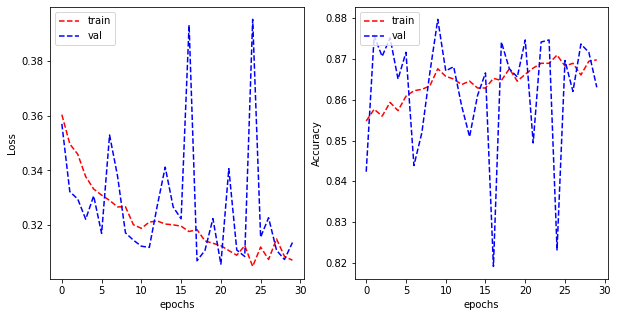

In [35]:
plot_learning_curve(base_history.history['loss'], base_history.history['val_loss'], 
                    base_history.history['categorical_accuracy'], base_history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

The model can be seen to have overfitting when plotted for both loss and accuracy.

#### **Predictions on Test Set**
The baseline model is applied to the test dataset and predicts whether images are cancerous or non-cancerous. The model was evaluated to have a loss of 30.76% and an accuracy of 87.63%.

In [36]:
base_model.evaluate(test_generator)

1980/1980 [==============================] - 4s 2ms/step - loss: 0.3170 - categorical_accuracy: 0.8763


[0.31696227192878723, 0.8762626051902771]

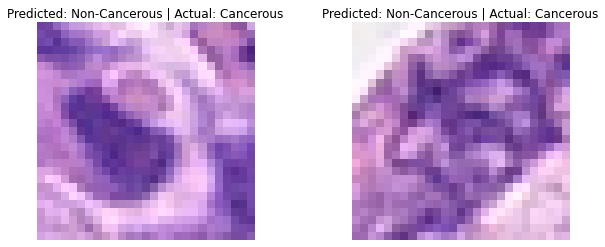

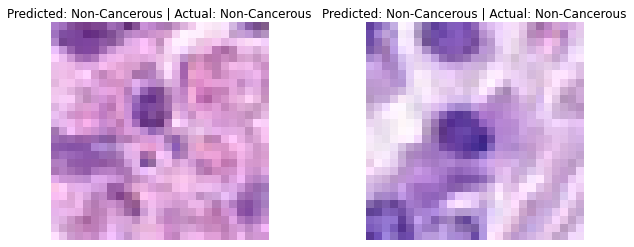

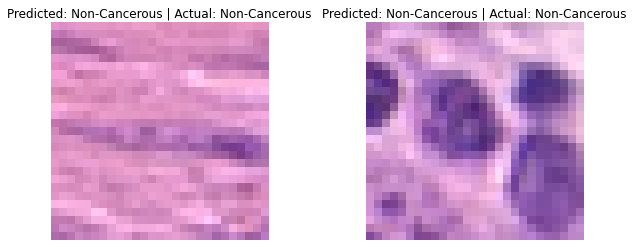

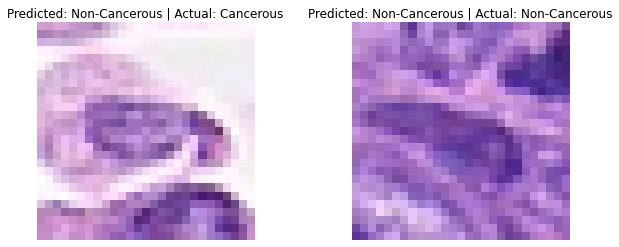

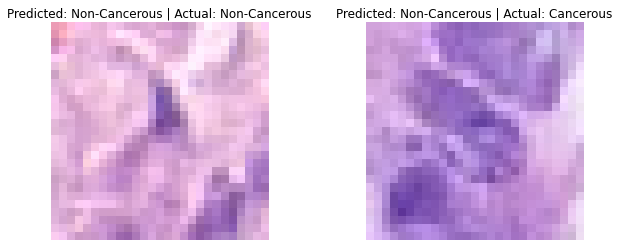

In [37]:
# Examples of the predicted results against the actual data on the test set
label_names = {'Non-Cancerous' : 0, 'Cancerous' : 1}

z = 0
while z < 5:
  d_inv = {v: k for k, v in label_names.items()}
  plt.figure(figsize=(16, 4))
  batches = 0
  for x, y in test_generator:
          batches = batches + 1
          y_hat = model.predict(x, verbose=0)
          x = np.squeeze(x)
          if batches < 3:
              plt.subplot(1, 3, batches)
              plt.imshow(x)
              plt.title("Predicted: {} | Actual: {}".format(d_inv[np.argmax(y_hat[0])], d_inv[np.argmax(y[0])]))
              
          else:
              break
          
          plt.axis('off')

  z = z + 1

## Adding Regularisation

In [17]:
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [18]:
model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [19]:
history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f3d1cfcac20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [ ]:
plot_learning_curve(history_reg.history_reg['loss'], history_reg.history_reg['val_loss'], 
                    history_reg.history_reg['categorical_accuracy'], history_reg.history_reg['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Bayesian Convolutional Neural Network
 

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [12]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

#### **Bayesian Model Building**

In [39]:
import tensorflow_probability as tfp

divergence_fn = lambda q,p,_:tfp.distributions.kl_divergence(q,p)/3457

model_bayes = tf.keras.Sequential([
    
    tfp.layers.Convolution2DReparameterization(input_shape = (27, 27, 3), filters = 8, kernel_size = 16, activation = 'relu',
                                                kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                                kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular = False),
                                                kernel_divergence_fn = divergence_fn,
                                                bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                                bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular=False),
                                                bias_divergence_fn = divergence_fn
                                            ),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tfp.layers.DenseReparameterization(units = tfp.layers.OneHotCategorical.params_size(2), activation = None,
                                        kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                        kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular = False),
                                        kernel_divergence_fn = divergence_fn,
                                        bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                        bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular = False),
                                        bias_divergence_fn = divergence_fn
                                    ),
    tfp.layers.OneHotCategorical(2)
])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [40]:
model_bayes.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_2  (None, 12, 12, 8)         12304     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          2336      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [41]:
from tensorflow.keras.optimizers import Adam

model_bayes.compile(loss = negative_log_likelihood,
                    optimizer = Adam(learning_rate=0.005),
                    metrics = ['accuracy'],
                    experimental_run_tf_function = False)

#### **Performance Measure**

In [42]:
history_bayes = model_bayes.fit(train_generator, validation_data = validation_generator, epochs = 10, verbose = 1)

Epoch 1/10
220/220 [==============================] - 9s 35ms/step - loss: 5.2750 - accuracy: 0.5019 - val_loss: 4.5585 - val_accuracy: 0.5068
Epoch 2/10
220/220 [==============================] - 7s 34ms/step - loss: 3.9142 - accuracy: 0.5001 - val_loss: 3.2797 - val_accuracy: 0.5159
Epoch 3/10
220/220 [==============================] - 8s 34ms/step - loss: 2.9160 - accuracy: 0.5142 - val_loss: 2.5533 - val_accuracy: 0.5124
Epoch 4/10
220/220 [==============================] - 8s 34ms/step - loss: 2.3558 - accuracy: 0.5157 - val_loss: 2.1760 - val_accuracy: 0.5189
Epoch 5/10
220/220 [==============================] - 7s 34ms/step - loss: 2.0458 - accuracy: 0.5114 - val_loss: 1.9156 - val_accuracy: 0.5099
Epoch 6/10
220/220 [==============================] - 8s 34ms/step - loss: 1.8092 - accuracy: 0.5188 - val_loss: 1.7001 - val_accuracy: 0.5447
Epoch 7/10
220/220 [==============================] - 7s 34ms/step - loss: 1.6528 - accuracy: 0.5235 - val_loss: 1.5550 - val_accuracy: 0.5296

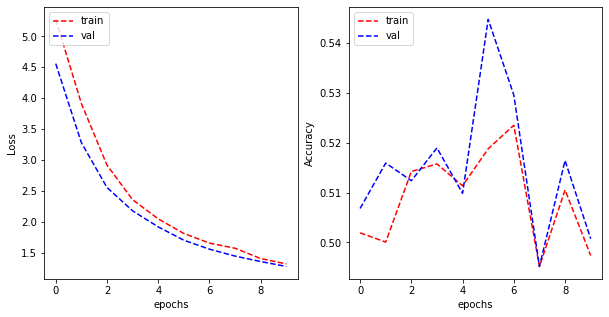

In [45]:
plot_learning_curve(history_bayes.history['loss'], history_bayes.history['val_loss'], 
                    history_bayes.history['accuracy'], history_bayes.history['val_accuracy'], 
                    metric_name = 'Accuracy')

#### **Predictions on Test Set**

In [46]:
model_bayes.evaluate(test_generator)

1980/1980 [==============================] - 6s 3ms/step - loss: 1.2729 - accuracy: 0.5051


[1.2728500366210938, 0.5050504803657532]